In [1]:
# Extract from Ann's data the Place Cells indexes

import os

parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, os.pardir))
os.sys.path.append(grandparent_directory)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from scipy.stats import pearsonr
import glob
from scipy.io import loadmat
import pandas as pd
import pickle as pkl

from tools.data_formatting import (
    get_smoothed_moving_all_data,
    get_common_indexes_n_recordings,
    smooth_tuning_curves_circularly,
    from_local_to_global_index,
)
from tools.data_manager import (
    get_all_experiments_runs,
    get_fovs_given_animal,
    find_path_to_data_folder,
)
from tools.alignment import procrustes, canoncorr
from params import (
    order_experiments,
    get_colors_for_each_experiment,
    animals,
    root_dir,
    experiments_to_exclude,
    results_colors,
)
from tools.decoders import make_k_decoders, apply_decoders

In [2]:
### Load all sessions ###

animal = "m135"
fov = "fov1"
sessions = get_all_experiments_runs(animal, fov)
# Remove sessions to exclude
sessions = [session for session in sessions if session not in experiments_to_exclude]
# Create a mapping of sessions and their chronological order
order_map = {value: index for index, value in enumerate(order_experiments)}
sessions = sorted(sessions, key=lambda x: order_map[x])

# Load the cells with the global index and the tuning curves
all_cells, all_tuning_curves, all_pc_idxs, all_phi, all_fr = [], [], [], [], []
for experiment, run in sessions:
    fr, _, phi, cells, tuning_curves, _ = get_smoothed_moving_all_data(
        animal, fov, experiment, run
    )
    # Load PC indexes
    path = [
        p
        for p in glob.glob(
            find_path_to_data_folder(animal, fov, experiment, run) + "/*",
            recursive=True,
        )
        if p.endswith("_PFmap_output.mat")
    ][0]
    pc_mat = loadmat(path)
    pc_ids = pc_mat["hist"][0][0]["SIspk"][0]["pcIdx"][0].squeeze()
    # Get the indexes of the Place Cells (their names are the local indexes)
    pc_idxs = np.where(np.isin(np.array(cells, dtype=float), pc_ids))[0]
    # Get the global IDs of the cells
    cells = from_local_to_global_index(animal, fov, (experiment, run), cells)
    all_cells.append(cells)
    all_tuning_curves.append(tuning_curves)
    all_pc_idxs.append(pc_idxs)
    all_phi.append(phi)
    all_fr.append(fr)

IndexError: list index out of range

# Using a reference session to make a decoder, find the accuracy after having removed the place cells from the target session

In [ ]:
# Smooth the tuning curves very little for better alignment
smoothed_tuning_curves = [
    smooth_tuning_curves_circularly(tuning_curves, 5)
    for tuning_curves in all_tuning_curves
]
results = {}
n_components = 20
for i, (ref_exp, ref_run) in enumerate(sessions):
    results[(ref_exp, ref_run)] = {}
    # Get the reference session
    ref_pc_idxs = all_pc_idxs[i]
    ref_tc = smoothed_tuning_curves[i]
    ref_cells = all_cells[i]
    ref_phi = all_phi[i]
    ref_fr = all_fr[i]
    # Get PCA components of reference session
    pca = PCA(n_components=n_components)
    pca_ref_tc = pca.fit_transform(ref_tc)
    pca_ref_fr = pca.transform(ref_fr)
    pca_ref_comp = pca.components_
    # Make decoders
    decoders, _, _, _, _ = make_k_decoders(pca_ref_fr, ref_phi, k=4, full_return=True)
    # Test them on the reference session without the place cells
    pca_ref_tc_wo_pc = pca.fit_transform(np.delete(ref_tc, ref_pc_idxs, axis=1))
    pca_ref_fr_wo_pc = pca.transform(np.delete(ref_fr, ref_pc_idxs, axis=1))
    A, B, _, _, _ = canoncorr(pca_ref_tc, pca_ref_tc_wo_pc, fullReturn=True)
    aligned_ref_fr_wo_pc = pca_ref_fr_wo_pc @ B @ np.linalg.inv(A)
    CMSEs_within_day, MDAs_within_day, pred_phis_within_day, real_phis_within_day = (
        apply_decoders(decoders, aligned_ref_fr_wo_pc, ref_phi)
    )
    results[(ref_exp, ref_run)]["within_day"] = {
        "CMSEs": CMSEs_within_day,
        "MDAs": MDAs_within_day,
        "pred_phis": pred_phis_within_day,
        "real_phis": real_phis_within_day,
    }
    # Align to other sessions excluding their PCs and decode
    for j, (exp, run) in enumerate(sessions):
        if i != j:
            # Get the other session to align to
            other_tc = smoothed_tuning_curves[j]
            other_pc_idxs = all_pc_idxs[j]
            other_phi = all_phi[j]
            other_fr = all_fr[j]
            # Remove the place cells from the tuning curves
            tc_wo_pc = np.delete(other_tc, other_pc_idxs, axis=1)
            fr_wo_pc = np.delete(other_fr, other_pc_idxs, axis=1)
            # Get the PCA components of the other session
            pca_tc_wo_pc = pca.fit_transform(tc_wo_pc)
            pca_fr_wo_pc = pca.transform(fr_wo_pc)
            # Align the tuning curves to the reference
            A, B, _, _, _ = canoncorr(pca_ref_tc, pca_tc_wo_pc, fullReturn=True)
            aligned_fr = pca_fr_wo_pc @ B @ np.linalg.inv(A)
            # Deocode
            CMSEs_other, MDAs_other, pred_phis_other, real_phis_other = apply_decoders(
                decoders, aligned_fr, other_phi
            )
            results[(ref_exp, ref_run)][(exp, run)] = {
                "CMSEs": CMSEs_other,
                "MDAs": MDAs_other,
                "pred_phis": pred_phis_other,
                "real_phis": real_phis_other,
            }

            ### Control - remove the same number of cells randomly ###

            # Generate 10 random samplings for each session (each tested on 4 decoders)
            (
                all_CMSEs_control,
                all_MDAs_control,
                all_pred_phis_control,
                all_real_phis_control,
            ) = [], [], [], []
            for _ in range(10):
                random_idxs = np.random.choice(
                    other_tc.shape[1], len(other_pc_idxs), replace=False
                )
                tc_wo_random = np.delete(other_tc, random_idxs, axis=1)
                fr_wo_random = np.delete(other_fr, random_idxs, axis=1)
                pca_tc_wo_random = pca.fit_transform(tc_wo_random)
                pca_fr_wo_random = pca.transform(fr_wo_random)
                A, B, _, _, _ = canoncorr(pca_ref_tc, pca_tc_wo_random, fullReturn=True)
                aligned_fr_random = pca_fr_wo_random @ B @ np.linalg.inv(A)
                CMSEs_control, MDAs_control, pred_phis_control, real_phis_control = (
                    apply_decoders(decoders, aligned_fr_random, other_phi)
                )
                all_CMSEs_control = np.concat([all_CMSEs_control, CMSEs_control])
                all_MDAs_control = np.concat([all_MDAs_control, MDAs_control])
                all_pred_phis_control.extend(pred_phis_control)
                all_real_phis_control.extend(real_phis_control)

            results[(ref_exp, ref_run)][(exp, run)]["control"] = {
                "CMSEs": all_CMSEs_control,
                "MDAs": all_MDAs_control,
                "pred_phis": all_pred_phis_control,
                "real_phis": all_real_phis_control,
            }

# Save the results
with open(
    f"{grandparent_directory}/data/fig3/fig3b/{animal}_{fov}_decoders_wo_place_cells.pkl",
    "wb",
) as f:
    pkl.dump(results, f)

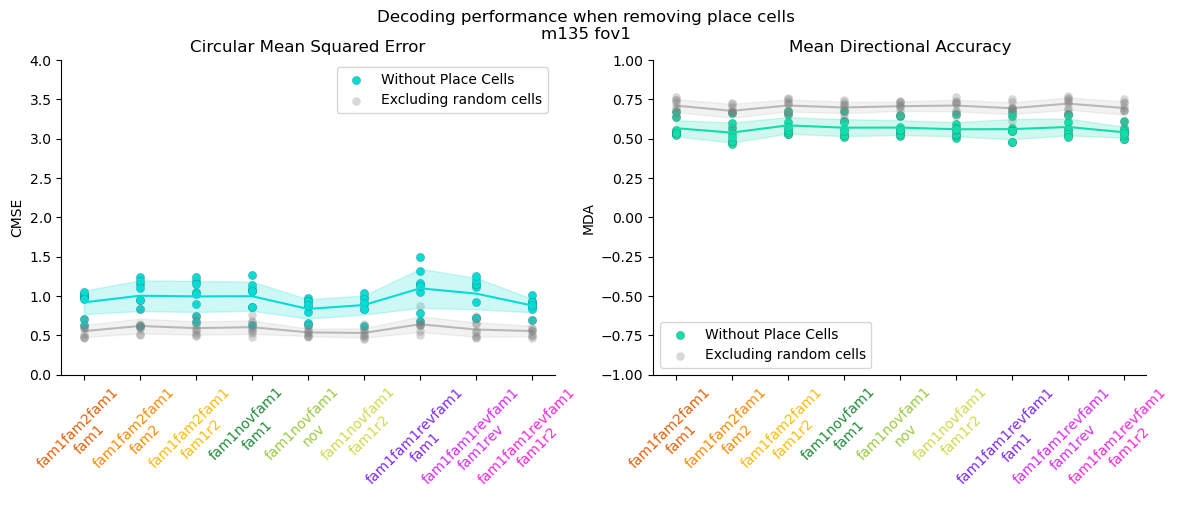

In [ ]:
# Plot the actual values not normalised
fig = plt.figure(figsize=(14, 5))
x_labels = list(results.keys())
x_labels = [f"{exp}\n{run}" for (exp, run) in x_labels]
grid = plt.GridSpec(nrows=1, ncols=2, hspace=0.2, wspace=0.2)

CMSEs, CMSEs_control, mean_per_session_CMSE, std_per_session_CMSE = [], [], [], []
MDAs, MDAs_control, mean_per_session_MDA, std_per_session_MDA = [], [], [], []
mean_CMSE_control, std_CMSE_control = [], []
mean_MDA_control, std_MDA_control = [], []
labels = []
for i, (ref_exp, ref_run) in enumerate(results):
    CMSE = [
        np.mean(results[(ref_exp, ref_run)][(exp, run)]["CMSEs"])
        for (exp, run) in sessions
        if (exp, run) in results[(ref_exp, ref_run)]
    ]  # Mean over the k decoders
    CMSEs.extend(CMSE)
    mean_per_session_CMSE.append(np.mean(CMSE))
    std_per_session_CMSE.append(np.std(CMSE))
    CMSE_control = [
        np.mean(results[(ref_exp, ref_run)][(exp, run)]["control"]["CMSEs"])
        for (exp, run) in sessions
        if (exp, run) in results[(ref_exp, ref_run)]
    ]
    CMSEs_control.extend(CMSE_control)
    mean_CMSE_control.append(np.mean(CMSE_control))
    std_CMSE_control.append(np.std(CMSE_control))

    MDA = [
        np.mean(results[(ref_exp, ref_run)][(exp, run)]["MDAs"])
        for (exp, run) in sessions
        if (exp, run) in results[(ref_exp, ref_run)]
    ]  # Mean over the k decoders
    MDAs.extend(MDA)
    mean_per_session_MDA.append(np.mean(MDA))
    std_per_session_MDA.append(np.std(MDA))
    MDA_control = [
        np.mean(results[(ref_exp, ref_run)][(exp, run)]["control"]["MDAs"])
        for (exp, run) in sessions
        if (exp, run) in results[(ref_exp, ref_run)]
    ]
    MDAs_control.extend(MDA_control)
    mean_MDA_control.append(np.mean(MDA_control))
    std_MDA_control.append(np.std(MDA_control))

    labels.extend([i for _ in range(len(sessions) - 1)])

mean_per_session_CMSE = np.array(mean_per_session_CMSE)
std_per_session_CMSE = np.array(std_per_session_CMSE)
mean_CMSE_control = np.array(mean_CMSE_control)
std_CMSE_control = np.array(std_CMSE_control)

mean_per_session_MDA = np.array(mean_per_session_MDA)
std_per_session_MDA = np.array(std_per_session_MDA)
mean_MDA_control = np.array(mean_MDA_control)
std_MDA_control = np.array(std_MDA_control)

# CMSE
ax = fig.add_subplot(grid[0, 0])
ax.scatter(
    labels,
    CMSEs,
    label="Without Place Cells",
    color=results_colors["CMSE"],
    edgecolors="black",
    linewidths=0.1,
)
ax.scatter(
    labels,
    CMSEs_control,
    label="Excluding random cells",
    color="grey",
    alpha=0.3,
    linewidths=0.1,
)
ax.plot(mean_per_session_CMSE, color=results_colors["CMSE"])
ax.fill_between(
    np.arange(len(sessions)),
    mean_per_session_CMSE - std_per_session_CMSE,
    mean_per_session_CMSE + std_per_session_CMSE,
    color=results_colors["CMSE"],
    alpha=0.2,
)
ax.plot(mean_CMSE_control, color="grey", alpha=0.5)
ax.fill_between(
    np.arange(len(sessions)),
    mean_CMSE_control - std_CMSE_control,
    mean_CMSE_control + std_CMSE_control,
    color="grey",
    alpha=0.1,
)

ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, fontsize=10)
ax.set_ylabel("CMSE")
[
    plt.gca().get_xticklabels()[i].set_color(color)
    for i, color in enumerate(get_colors_for_each_experiment(sessions))
]
ax.set_ylim(0, 4)
ax.spines[["top", "right"]].set_visible(False)
ax.set_title("Circular Mean Squared Error")
ax.legend()

# MDA
ax = fig.add_subplot(grid[0, 1])
ax.scatter(
    labels,
    MDAs,
    label="Without Place Cells",
    color=results_colors["MDA"],
    edgecolors="black",
    linewidths=0.1,
)
ax.scatter(
    labels,
    MDAs_control,
    label="Excluding random cells",
    color="grey",
    alpha=0.3,
    linewidths=0.1,
)
ax.plot(mean_per_session_MDA, color=results_colors["MDA"])
ax.fill_between(
    np.arange(len(sessions)),
    mean_per_session_MDA - std_per_session_MDA,
    mean_per_session_MDA + std_per_session_MDA,
    color=results_colors["MDA"],
    alpha=0.2,
)
ax.plot(mean_MDA_control, color="grey", alpha=0.5)
ax.fill_between(
    np.arange(len(sessions)),
    mean_MDA_control - std_MDA_control,
    mean_MDA_control + std_MDA_control,
    color="grey",
    alpha=0.1,
)

ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, fontsize=10)
ax.set_ylabel("MDA")
[
    plt.gca().get_xticklabels()[i].set_color(color)
    for i, color in enumerate(get_colors_for_each_experiment(sessions))
]
ax.set_ylim(-1, 1)
ax.spines[["top", "right"]].set_visible(False)
ax.set_title("Mean Directional Accuracy")
ax.legend()

fig.subplots_adjust(bottom=0.25)  # to make space for the x labels that get cropped
fig.suptitle(f"Decoding performance when removing place cells\n{animal} {fov}")
plt.savefig(f"{os.getcwd()}/plots/fig3b_1.pdf")
plt.savefig(f"{os.getcwd()}/plots/PNGs/fig3b_1.png", dpi=300)
plt.show()
plt.close("all")

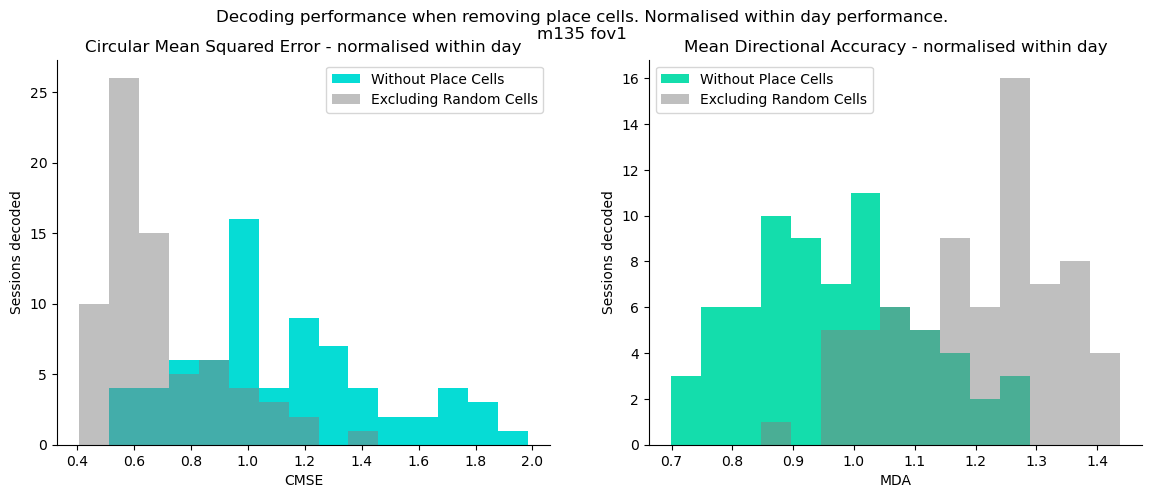

In [ ]:
# Plot the results normalised within day
fig = plt.figure(figsize=(14, 5))
grid = plt.GridSpec(nrows=1, ncols=2, hspace=0.2, wspace=0.2)
n_bins = 15

norm_CMSEs = []
norm_MDAs = []
MDAs_control = []
CMSEs_control = []

for ref_exp, ref_run in results:
    # Values to use for normalization
    within_day_CMSE = np.mean(results[(ref_exp, ref_run)]["within_day"]["CMSEs"])
    within_day_MDA = np.mean(results[(ref_exp, ref_run)]["within_day"]["MDAs"])
    # Variables to save decoding performance across sessions
    for exp, run in sessions:
        if (exp, run) in results[(ref_exp, ref_run)]:
            CMSE = np.mean(results[(ref_exp, ref_run)][(exp, run)]["CMSEs"])
            MDA = np.mean(results[(ref_exp, ref_run)][(exp, run)]["MDAs"])
            norm_CMSEs.append(CMSE / within_day_CMSE)
            norm_MDAs.append(MDA / within_day_MDA)
            CMSE_control = np.mean(
                results[(ref_exp, ref_run)][(exp, run)]["control"]["CMSEs"]
            )
            MDA_control = np.mean(
                results[(ref_exp, ref_run)][(exp, run)]["control"]["MDAs"]
            )
            CMSEs_control.append(CMSE_control / within_day_CMSE)
            MDAs_control.append(MDA_control / within_day_MDA)

bins = np.histogram(np.hstack((norm_CMSEs, CMSEs_control)), bins=n_bins)[1]
ax = fig.add_subplot(grid[0, 0])
ax.hist(
    x=np.array(norm_CMSEs),
    bins=bins,
    label="Without Place Cells",
    color=results_colors["CMSE"],
)
ax.hist(
    x=np.array(CMSEs_control),
    bins=bins,
    label="Excluding Random Cells",
    color="grey",
    alpha=0.5,
)
#ax.set_xticks(np.arange(1, np.max(CMSEs_control), 1))

ax.set_title("Circular Mean Squared Error - normalised within day")
ax.set_xlabel("CMSE")
ax.set_ylabel("Sessions decoded")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

bins = np.histogram(np.hstack((norm_MDAs, MDAs_control)), bins=n_bins)[1]
ax = fig.add_subplot(grid[0, 1])
ax.hist(
    x=np.array(norm_MDAs),
    bins=bins,
    label="Without Place Cells",
    color=results_colors["MDA"],
)
ax.hist(
    x=np.array(MDAs_control),
    bins=bins,
    label="Excluding Random Cells",
    color="grey",
    alpha=0.5,
)
#ax.set_xlim(-1, 1)

ax.set_title("Mean Directional Accuracy - normalised within day")
ax.set_xlabel("MDA")
ax.set_ylabel("Sessions decoded")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

fig.suptitle(
    f"Decoding performance when removing place cells. Normalised within day performance.\n{animal} {fov}"
)
plt.savefig(f"{os.getcwd()}/plots/fig3b_2.pdf")
plt.savefig(f"{os.getcwd()}/plots/PNGs/fig3b_2.png", dpi=300)
plt.show()
plt.close("all")